In [1]:
from environment import Environment
from discreteAgent import Agent
from discreteTrainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
import json
from easydict import EasyDict
from datetime import date
import os
import torch

# Environment Params

In [3]:
args = EasyDict()
args.ENV_NAME = 'Bottleneck' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #
args.continuous=False

In [4]:
env = Environment.bottleneck(initial_state_range=0)

In [5]:
env.N_obs

18

# Trainer Params

In [6]:
args.monte_carlo = True
args.augmentation = True
args.final = True 

In [111]:
ALPHA_REF = 0.03 # le alpha qui sert à apprendre Q_ref (PREC inclus)
BETA_REF = 1 #100 # amplification du reward

args.PREC = 0.01 / BETA_REF  # poids relatif des 2 termes dans la mise à jour explo/exploit
args.Q_VAR_MULT = 1

if False:
    args.ALPHA = ALPHA_REF / args.Q_VAR_MULT / args.PREC  # la division par PREC assure la même "vitesse d'app"
                                                          # quelle que soit la valeur de PREC
else:
    args.ALPHA = ALPHA_REF



args.OBS_LEAK = args.ALPHA / env.N_obs #1e-3  #3e-3 
# OBS_LEAK regule la valeur de KL (si faible : atténue les pics pour les etats 'nouveaux', favorise le 'turn over')



In [112]:
args.ALPHA, args.PREC, args.OBS_LEAK

(0.03, 0.01, 0.0016666666666666666)

(0.33333333333333337, 0.03, 0.01851851851851852)

# Agent Params

In [113]:
args.isTime = True
args.offPolicy = False
args.BETA = BETA_REF 

args.GAMMA = 1
args.do_reward = None
args.HIST_HORIZON = 200 * int(1/args.OBS_LEAK)

args.act_renorm = False
args.retain_present = False
args.retain_trajectory = False

args.KL_centering = True
args.rtg_centering = True

# Data path

In [114]:
data_path = "data/{}/{}-{}".format(args.ENV_NAME,str(date.today()),args.ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'

data_path += '-LEAK-{}'.format(args.OBS_LEAK)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
data_path += '-ALPHA-{}'.format(ALPHA_REF)



In [115]:
data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'

In [116]:
if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [117]:
data_path_npy

'data/Bottleneck/2021-04-29-Bottleneck-final-no-reward-LEAK-0.0016666666666666666-GAMMA-1-BETA-1-PREC-0.01-ALPHA-0.03.npy'

In [156]:
N = 3000 # Number of episodes
NB_TRIALS = 1

In [157]:
args.do_reward = False  # True #
verbose = True

In [158]:
mem_Q_var = []
mem_Q_ref = []
mem_Q_KL = []
BETA= args.BETA
agent = Agent(env,
              ALPHA=args.ALPHA,
              GAMMA=args.GAMMA, # Episodic agent!
              BETA=BETA, 
              PREC=args.PREC,
              do_reward=args.do_reward,
              isTime=args.isTime,    #!! TimeAgent
              offPolicy=False,
              Q_VAR_MULT=args.Q_VAR_MULT) 

In [159]:
trainer = Final_variational_trainer(agent, 
                                    monte_carlo=args.monte_carlo, 
                                    final= args.final,
                                    augmentation=args.augmentation,
                                    OBS_LEAK=args.OBS_LEAK,
                                    ref_prob='unif',
                                    KL_centering=args.KL_centering,
                                    rtg_centering=args.rtg_centering) #[2,5] # 

In [160]:
mem_total_reward = {}
nb_visits_final = {}

In [161]:
for trial in range(N):

    trainer.run_episode(verbose=verbose)
    mem_Q_var.append(np.array(agent.Q_var_tab))
    mem_Q_ref.append(np.array(agent.Q_ref_tab))     
    if not args.monte_carlo:
        mem_Q_KL.append(np.array(agent.Q_KL_tab))     

    if True: #trial%100 == 0:
        print(trial)
        print("Trajectory: ", trainer.trajectory)
        print("Total reward got: %.4f" % trainer.total_reward)
        obs = env.state
        print(np.mean(trainer.obs_score), trainer.obs_score[obs])
        
    mem_total_reward[trial] = trainer.mem_total_reward
    nb_visits_final[trial] = trainer.nb_visits_final


/home/dauce/Recherche/scripts/VariationalRL/discreteTrainer.py:80: RuntimeWarning: divide by zero encountered in long_scalars
  p[np.where(self.nb_visits_final > 0)] = 1 / np.sum(self.nb_visits_final > 0)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


obs: 2 final KL loss: 0.0
Time elapsed : 0.00620999999999583
0
Trajectory:  [0, 1, 0, 0, 6, 7, 8, 2]
Total reward got: 0.0000
0.3869498366859518 1.0
obs: 12 final KL loss: 0.0008336807485773701
Time elapsed : 0.002664999999993256
1
Trajectory:  [0, 1, 1, 0, 0, 6, 12, 12]
Total reward got: 0.0000
0.7694077680885649 1.9983333333333333
obs: 12 final KL loss: 0.28851552133261843
Time elapsed : 0.0019800000000032014
2
Trajectory:  [0, 0, 1, 1, 7, 13, 13, 12]
Total reward got: 0.0000
1.147425938468313 2.9751356906240094
obs: 0 final KL loss: -0.2851817258091067
Time elapsed : 0.001695999999995479
3
Trajectory:  [0, 6, 0, 1, 0, 0, 0, 0]
Total reward got: 0.0000
1.5210558867692783 9.81943038376769
obs: 7 final KL loss: -0.2198102195256295
Time elapsed : 0.002084000000010633
4
Trajectory:  [0, 6, 7, 8, 7, 1, 1, 7]
Total reward got: 0.0000
1.8903485536459625 4.909933788146983
obs: 4 final KL loss: -0.17815547172653035
Time elapsed : 0.0019709999999975025
5
Trajectory:  [0, 1, 7, 8, 9, 3, 3, 4]
T

obs: 12 final KL loss: 0.7223480873206987
Time elapsed : 0.0023350000000021964
95
Trajectory:  [0, 6, 12, 6, 12, 12, 12, 12]
Total reward got: 0.0000
22.467497652933837 31.72158193569514
obs: 13 final KL loss: -0.17698049307689034
Time elapsed : 0.0020209999999991624
96
Trajectory:  [0, 1, 0, 0, 6, 12, 12, 13]
Total reward got: 0.0000
22.593633653193447 20.93083978702621
obs: 14 final KL loss: -0.6255170775432992
Time elapsed : 0.0022710000000074615
97
Trajectory:  [0, 0, 6, 6, 12, 13, 14, 14]
Total reward got: 0.0000
22.718305404312026 8.006862270557
obs: 12 final KL loss: 0.758031376092325
Time elapsed : 0.0033130000000056725
98
Trajectory:  [0, 0, 0, 6, 12, 12, 12, 12]
Total reward got: 0.0000
22.84152990401857 37.552059502643935
obs: 14 final KL loss: -0.40885101211642416
Time elapsed : 0.0033400000000085583
99
Trajectory:  [0, 0, 6, 6, 7, 13, 13, 14]
Total reward got: 0.0000
22.963323952723997 8.822046009687543
obs: 0 final KL loss: 0.013582780720044152
Time elapsed : 0.0026340000

obs: 14 final KL loss: 0.22008677692846357
Time elapsed : 0.0016789999999957672
181
Trajectory:  [0, 6, 12, 12, 13, 14, 14, 14]
Total reward got: 0.0000
29.35265137460611 14.928538496272203
obs: 8 final KL loss: 0.21823810564415913
Time elapsed : 0.0016430000000013933
182
Trajectory:  [0, 0, 0, 6, 7, 13, 14, 8]
Total reward got: 0.0000
29.398861101620955 25.511945262825947
obs: 8 final KL loss: 0.29508728406932505
Time elapsed : 0.0037049999999965166
183
Trajectory:  [0, 6, 0, 6, 7, 8, 2, 8]
Total reward got: 0.0000
29.444534403246134 27.212459415680637
obs: 2 final KL loss: 0.29550921101876826
Time elapsed : 0.00269700000001194
184
Trajectory:  [0, 0, 1, 0, 6, 7, 8, 2]
Total reward got: 0.0000
29.48967750657318 42.5167034048314
obs: 1 final KL loss: 0.9067786926545782
Time elapsed : 0.0022069999999985157
185
Trajectory:  [0, 1, 0, 0, 1, 0, 0, 1]
Total reward got: 0.0000
29.534296566406436 83.46326077204887
obs: 6 final KL loss: 0.8691956267597638
Time elapsed : 0.0021780000000006794
1

obs: 14 final KL loss: 0.5287700137581206
Time elapsed : 0.001986999999999739
253
Trajectory:  [0, 1, 0, 0, 6, 7, 13, 14]
Total reward got: 0.0000
31.616034909344574 27.498028375861058
obs: 9 final KL loss: -0.8226014404224893
Time elapsed : 0.004581000000001723
254
Trajectory:  [0, 6, 12, 12, 13, 7, 8, 9]
Total reward got: 0.0000
31.63597015968567 7.990770013913354
obs: 13 final KL loss: 0.45011126513386257
Time elapsed : 0.002981999999988716
255
Trajectory:  [0, 6, 6, 12, 12, 13, 13, 13]
Total reward got: 0.0000
31.655673991770854 34.17557094935896
obs: 6 final KL loss: 0.742417081062194
Time elapsed : 0.0024310000000014043
256
Trajectory:  [0, 0, 6, 7, 6, 0, 6, 6]
Total reward got: 0.0000
31.67514909201782 88.48988981352142
obs: 13 final KL loss: 0.4913770935055757
Time elapsed : 0.002619000000009919
257
Trajectory:  [0, 6, 12, 13, 14, 13, 14, 13]
Total reward got: 0.0000
31.694398115658974 36.37674188227363
obs: 2 final KL loss: 0.45975001870870535
Time elapsed : 0.0026889999999895

obs: 14 final KL loss: 0.6537302457484593
Time elapsed : 0.0019759999999990896
337
Trajectory:  [0, 0, 6, 6, 6, 12, 13, 14]
Total reward got: 0.0000
32.689338903941625 34.381565204138916
obs: 2 final KL loss: 0.6826144065170445
Time elapsed : 0.0017950000000013233
338
Trajectory:  [0, 1, 2, 1, 2, 2, 2, 2]
Total reward got: 0.0000
32.696814710120016 66.95324445159413
obs: 15 final KL loss: -1.5052307893820487
Time elapsed : 0.0038049999999998363
339
Trajectory:  [0, 6, 7, 8, 9, 8, 9, 15]
Total reward got: 0.0000
32.704203733439 3.8794763200609834
obs: 8 final KL loss: 0.2959306869946805
Time elapsed : 0.002604999999988422
340
Trajectory:  [0, 0, 1, 1, 7, 8, 7, 8]
Total reward got: 0.0000
32.711506981316994 40.6076797854744
obs: 2 final KL loss: 0.7038370342252254
Time elapsed : 0.0028970000000043683
341
Trajectory:  [0, 1, 2, 2, 2, 8, 2, 2]
Total reward got: 0.0000
32.71872544947777 69.62691381285596
obs: 8 final KL loss: 0.3358517786527031
Time elapsed : 0.002665000000007467
342
Trajec

obs: 8 final KL loss: 0.5727743365822136
Time elapsed : 0.0020130000000051496
427
Trajectory:  [0, 0, 1, 2, 2, 2, 2, 8]
Total reward got: 0.0000
33.108172693422915 55.32964942837096
obs: 2 final KL loss: 0.8712997036349175
Time elapsed : 0.0017199999999917281
428
Trajectory:  [0, 6, 7, 1, 2, 2, 2, 2]
Total reward got: 0.0000
33.11078646960814 88.58929330731658
obs: 1 final KL loss: 0.6944178534100689
Time elapsed : 0.0037870000000026494
429
Trajectory:  [0, 0, 0, 1, 2, 1, 0, 1]
Total reward got: 0.0000
33.11336990378534 94.56854049192442
obs: 6 final KL loss: 0.36911016422380216
Time elapsed : 0.002997000000007688
430
Trajectory:  [0, 1, 2, 1, 1, 1, 7, 6]
Total reward got: 0.0000
33.11592334817955 77.60486183527108
obs: 14 final KL loss: 0.7254638702289591
Time elapsed : 0.002494999999996139
431
Trajectory:  [0, 6, 12, 12, 13, 14, 14, 14]
Total reward got: 0.0000
33.118447150927004 30.250577169168633
obs: 8 final KL loss: 0.5893813611040453
Time elapsed : 0.0020959999999945467
432
Traj

obs: 9 final KL loss: -0.27932687308190474
Time elapsed : 0.0019389999999930296
517
Trajectory:  [0, 6, 6, 7, 8, 7, 8, 9]
Total reward got: 0.0000
33.254610115474186 22.862242645011353
obs: 2 final KL loss: 0.9684589221799671
Time elapsed : 0.0016590000000036298
518
Trajectory:  [0, 1, 1, 1, 2, 2, 2, 2]
Total reward got: 0.0000
33.255523973562994 85.91754465976682
obs: 9 final KL loss: -0.2185569529284539
Time elapsed : 0.0022620000000017626
519
Trajectory:  [0, 1, 2, 1, 2, 2, 8, 9]
Total reward got: 0.0000
33.256427223134665 23.33453103240142
obs: 1 final KL loss: 0.5666235672583935
Time elapsed : 0.0017859999999956244
520
Trajectory:  [0, 6, 7, 6, 7, 13, 7, 1]
Total reward got: 0.0000
33.2573199873381 88.79580205117824
obs: 9 final KL loss: -0.16172246507528998
Time elapsed : 0.001784000000000674
521
Trajectory:  [0, 0, 6, 7, 8, 7, 8, 9]
Total reward got: 0.0000
33.25820238789266 23.795917949170406
obs: 15 final KL loss: -0.8003333375851045
Time elapsed : 0.0025059999999967886
522
Tr

obs: 14 final KL loss: 1.0813954636529988
Time elapsed : 0.002038000000013085
610
Trajectory:  [0, 0, 6, 12, 13, 14, 14, 14]
Total reward got: 0.0000
33.30675668477059 50.83980962022539
obs: 9 final KL loss: -0.1179280122122135
Time elapsed : 0.0019400000000047157
611
Trajectory:  [0, 0, 0, 0, 1, 2, 8, 9]
Total reward got: 0.0000
33.30706519966522 21.32282823786374
obs: 2 final KL loss: 1.0206611311732283
Time elapsed : 0.0017460000000113496
612
Trajectory:  [0, 0, 1, 1, 1, 2, 2, 2]
Total reward got: 0.0000
33.307370133166195 97.98656057805749
obs: 8 final KL loss: 0.5656585410115684
Time elapsed : 0.0021129999999942584
613
Trajectory:  [0, 0, 1, 7, 8, 2, 2, 8]
Total reward got: 0.0000
33.307671526848125 51.1114211070183
obs: 14 final KL loss: 1.086873160470751
Time elapsed : 0.002071000000000822
614
Trajectory:  [0, 0, 1, 2, 8, 14, 14, 14]
Total reward got: 0.0000
33.30796942180298 51.51490664685092
obs: 8 final KL loss: 0.5867838599973418
Time elapsed : 0.0020020000000045
615
Traject

obs: 4 final KL loss: -1.1306593666143194
Time elapsed : 0.002232000000006451
695
Trajectory:  [0, 6, 7, 8, 9, 10, 4, 4]
Total reward got: 0.0000
33.32348266817385 4.619568790202367
obs: 14 final KL loss: 1.0523341786484668
Time elapsed : 0.0016700000000042792
696
Trajectory:  [0, 0, 6, 12, 13, 14, 13, 14]
Total reward got: 0.0000
33.323597019572084 36.16722132815591
obs: 8 final KL loss: 0.6926032762205323
Time elapsed : 0.0033859999999918955
697
Trajectory:  [0, 0, 6, 0, 0, 6, 7, 8]
Total reward got: 0.0000
33.32371004352267 54.04151066277798
obs: 14 final KL loss: 1.0626573880835815
Time elapsed : 0.0015849999999915099
698
Trajectory:  [0, 6, 7, 8, 14, 14, 14, 14]
Total reward got: 0.0000
33.32382175543528 39.32241220343553
obs: 9 final KL loss: -0.04135330312121965
Time elapsed : 0.003216999999992254
699
Trajectory:  [0, 1, 2, 2, 2, 2, 8, 9]
Total reward got: 0.0000
33.3239321705407 24.434739890363034
obs: 15 final KL loss: -0.664462734750566
Time elapsed : 0.0014529999999979282
70

obs: 0 final KL loss: -0.21749886011169828
Time elapsed : 0.0023580000000009704
786
Trajectory:  [0, 6, 0, 0, 6, 0, 0, 0]
Total reward got: 0.0000
33.32992921283614 75.5885712748356
obs: 7 final KL loss: 0.3157975006702327
Time elapsed : 0.0021839999999997417
787
Trajectory:  [0, 0, 1, 2, 2, 2, 8, 7]
Total reward got: 0.0000
33.32996872955224 54.99750578618253
obs: 14 final KL loss: 0.9900393055948904
Time elapsed : 0.0038700000000062573
788
Trajectory:  [0, 6, 6, 0, 1, 7, 13, 14]
Total reward got: 0.0000
33.33000778753874 36.32325637386751
obs: 1 final KL loss: 0.3956231270909991
Time elapsed : 0.002640999999997007
789
Trajectory:  [0, 0, 0, 1, 2, 2, 2, 1]
Total reward got: 0.0000
33.330046392120806 84.94321925451412
obs: 1 final KL loss: 0.42059972746769914
Time elapsed : 0.0024460000000061655
790
Trajectory:  [0, 1, 2, 2, 2, 2, 2, 1]
Total reward got: 0.0000
33.33008454856176 85.94719788416043
obs: 8 final KL loss: 0.7753545258855765
Time elapsed : 0.0018709999999941829
791
Trajecto

obs: 14 final KL loss: 1.0267276574468163
Time elapsed : 0.002277000000006524
876
Trajectory:  [0, 6, 7, 13, 13, 14, 8, 14]
Total reward got: 0.0000
33.332143146097515 41.7697648198306
obs: 15 final KL loss: -0.6446401568664033
Time elapsed : 0.0026859999999970796
877
Trajectory:  [0, 6, 7, 8, 7, 8, 9, 15]
Total reward got: 0.0000
33.332156962380196 10.080754735137628
obs: 2 final KL loss: 1.0124012498458752
Time elapsed : 0.0050290000000075
878
Trajectory:  [0, 1, 0, 1, 2, 2, 1, 2]
Total reward got: 0.0000
33.332170618276635 105.78658061066227
obs: 14 final KL loss: 1.0341761030078682
Time elapsed : 0.0017610000000019
879
Trajectory:  [0, 6, 0, 6, 12, 13, 13, 14]
Total reward got: 0.0000
33.33218411564867 41.33193347189073
obs: 4 final KL loss: -1.250277336980305
Time elapsed : 0.0026299999999963575
880
Trajectory:  [0, 0, 1, 7, 8, 9, 10, 4]
Total reward got: 0.0000
33.33219745633652 2.7007365080885553
obs: 14 final KL loss: 1.0436526517340714
Time elapsed : 0.002840000000006171
881
T

obs: 2 final KL loss: 1.0374167453181586
Time elapsed : 0.0022939999999920246
957
Trajectory:  [0, 6, 0, 1, 7, 8, 2, 2]
Total reward got: 0.0000
33.33287109642898 116.42798483737351
obs: 14 final KL loss: 1.0790291154411609
Time elapsed : 0.002586000000007971
958
Trajectory:  [0, 6, 7, 8, 7, 13, 13, 14]
Total reward got: 0.0000
33.3328764623038 44.77015141015606
obs: 6 final KL loss: -0.15375055632331058
Time elapsed : 0.0019419999999996662
959
Trajectory:  [0, 0, 6, 6, 12, 12, 6, 6]
Total reward got: 0.0000
33.33288176588891 63.82156760523251
obs: 6 final KL loss: -0.11288072969213614
Time elapsed : 0.002060000000000173
960
Trajectory:  [0, 6, 7, 8, 7, 13, 7, 6]
Total reward got: 0.0000
33.33288700790735 65.07073682456564
obs: 8 final KL loss: 0.7945962951043604
Time elapsed : 0.00413000000000352
961
Trajectory:  [0, 0, 0, 1, 2, 2, 2, 8]
Total reward got: 0.0000
33.332892189073874 58.68102368044402
obs: 2 final KL loss: 1.040321611813171
Time elapsed : 0.0027169999999898664
962
Trajec

obs: 2 final KL loss: 1.108767941597435
Time elapsed : 0.0016889999999989413
1034
Trajectory:  [0, 6, 12, 6, 7, 1, 2, 2]
Total reward got: 0.0000
33.33314522937783 127.00442444377153
obs: 14 final KL loss: 1.073173018734566
Time elapsed : 0.0017089999999910788
1035
Trajectory:  [0, 0, 6, 12, 13, 14, 14, 14]
Total reward got: 0.0000
33.33314741298167 43.401909440835
obs: 8 final KL loss: 0.7594347310903862
Time elapsed : 0.0019259999999974298
1036
Trajectory:  [0, 1, 2, 1, 2, 2, 2, 8]
Total reward got: 0.0000
33.333149571237136 51.88846225298931
obs: 15 final KL loss: -0.5483779428701978
Time elapsed : 0.004517000000006988
1037
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 15]
Total reward got: 0.0000
33.33315170443852 10.52757566555011
obs: 7 final KL loss: 0.17207428951644754
Time elapsed : 0.003467000000000553
1038
Trajectory:  [0, 0, 1, 7, 1, 2, 8, 7]
Total reward got: 0.0000
33.33315381287665 52.06611969776558
obs: 2 final KL loss: 1.1107007874672612
Time elapsed : 0.0027719999999931133
103

obs: 13 final KL loss: 0.4737233260301501
Time elapsed : 0.003471999999987929
1097
Trajectory:  [0, 1, 2, 8, 14, 14, 14, 13]
Total reward got: 0.0000
33.3332431917495 37.3478482602799
obs: 14 final KL loss: 1.0715170169594583
Time elapsed : 0.0023529999999993834
1098
Trajectory:  [0, 6, 12, 6, 12, 13, 14, 14]
Total reward got: 0.0000
33.333244238157626 48.958956008223765
obs: 2 final KL loss: 1.0628828319189203
Time elapsed : 0.005468999999990842
1099
Trajectory:  [0, 0, 0, 0, 1, 2, 2, 2]
Total reward got: 0.0000
33.33324527241852 108.70446271588419
obs: 7 final KL loss: 0.2539616768177022
Time elapsed : 0.002586999999991235
1100
Trajectory:  [0, 0, 1, 7, 8, 9, 8, 7]
Total reward got: 0.0000
33.33324629467322 57.45161534084125
obs: 14 final KL loss: 1.0777799290007462
Time elapsed : 0.0033169999999955735
1101
Trajectory:  [0, 1, 2, 2, 2, 8, 14, 14]
Total reward got: 0.0000
33.33324730506107 49.2719860602321
obs: 6 final KL loss: -0.22170312141621995
Time elapsed : 0.0022709999999932506

obs: 1 final KL loss: 0.29927205211245145
Time elapsed : 0.003253999999998314
1171
Trajectory:  [0, 0, 0, 6, 7, 1, 7, 1]
Total reward got: 0.0000
33.33329534314133 82.95234257761214
obs: 14 final KL loss: 1.1041655962450672
Time elapsed : 0.0017720000000025493
1172
Trajectory:  [0, 1, 1, 0, 1, 7, 13, 14]
Total reward got: 0.0000
33.33329578415028 50.295237898373045
obs: 10 final KL loss: -0.3174887797162018
Time elapsed : 0.0027930000000111477
1173
Trajectory:  [0, 6, 7, 8, 9, 10, 11, 10]
Total reward got: 0.0000
33.33329622003978 14.317342819150774
obs: 7 final KL loss: 0.2735874344743552
Time elapsed : 0.004305999999999699
1174
Trajectory:  [0, 0, 1, 0, 1, 2, 8, 7]
Total reward got: 0.0000
33.333296650869244 68.41601713906898
obs: 6 final KL loss: -0.11588910288913246
Time elapsed : 0.002628000000001407
1175
Trajectory:  [0, 6, 0, 1, 7, 8, 7, 6]
Total reward got: 0.0000
33.33329707669745 71.1695004841367
obs: 6 final KL loss: -0.07931707987965808
Time elapsed : 0.0023180000000024847


1250
Trajectory:  [0, 0, 0, 1, 2, 2, 2, 1]
Total reward got: 0.0000
33.3333182303473 87.53813489536452
obs: 2 final KL loss: 1.0034573731791003
Time elapsed : 0.0017509999999987258
1251
Trajectory:  [0, 0, 1, 2, 2, 2, 2, 2]
Total reward got: 0.0000
33.33331840567023 113.44501909371675
obs: 14 final KL loss: 1.0003333859987074
Time elapsed : 0.001586000000003196
1252
Trajectory:  [0, 6, 7, 8, 14, 8, 14, 14]
Total reward got: 0.0000
33.333318578957936 49.96558756832607
obs: 9 final KL loss: -0.051086499713285605
Time elapsed : 0.003797999999989088
1253
Trajectory:  [0, 6, 6, 7, 8, 9, 10, 9]
Total reward got: 0.0000
33.333318750234014 24.233592353359
obs: 13 final KL loss: 0.5222064454384308
Time elapsed : 0.00259700000000862
1254
Trajectory:  [0, 6, 7, 13, 14, 14, 14, 13]
Total reward got: 0.0000
33.33331891952184 36.7531875194352
obs: 15 final KL loss: -0.6950760897685426
Time elapsed : 0.0025600000000025602
1255
Trajectory:  [0, 6, 7, 8, 9, 15, 15, 15]
Total reward got: 0.0000
33.33331

obs: 0 final KL loss: -0.15458332954872933
Time elapsed : 0.0023529999999993834
1327
Trajectory:  [0, 6, 7, 6, 7, 1, 0, 0]
Total reward got: 0.0000
33.333327187282265 45.675655236775164
obs: 1 final KL loss: 0.44204040591400195
Time elapsed : 0.0017640000000085365
1328
Trajectory:  [0, 1, 1, 2, 2, 1, 2, 1]
Total reward got: 0.0000
33.333327258628664 69.74445932611621
obs: 12 final KL loss: -0.14728573164217318
Time elapsed : 0.0017769999999899255
1329
Trajectory:  [0, 6, 7, 8, 14, 14, 13, 12]
Total reward got: 0.0000
33.33332732914684 18.137029606808
obs: 6 final KL loss: -0.1755545137432608
Time elapsed : 0.0038880000000034443
1330
Trajectory:  [0, 6, 7, 8, 9, 8, 7, 6]
Total reward got: 0.0000
33.33332739884639 73.78355029992602
obs: 14 final KL loss: 0.9535558798489234
Time elapsed : 0.0027589999999975134
1331
Trajectory:  [0, 6, 7, 13, 14, 14, 14, 14]
Total reward got: 0.0000
33.33332746773685 52.23508657474827
obs: 5 final KL loss: -1.8267296362852856
Time elapsed : 0.0035960000000

obs: 13 final KL loss: 0.5480174794042538
Time elapsed : 0.002942000000004441
1408
Trajectory:  [0, 6, 12, 13, 14, 14, 14, 13]
Total reward got: 0.0000
33.333330946370936 35.80571220903471
obs: 8 final KL loss: 0.668130530233586
Time elapsed : 0.0019620000000060145
1409
Trajectory:  [0, 0, 1, 2, 1, 2, 2, 8]
Total reward got: 0.0000
33.33333097407997 58.489749267107314
obs: 9 final KL loss: -0.09228484915150137
Time elapsed : 0.0047739999999976135
1410
Trajectory:  [0, 0, 1, 2, 8, 9, 10, 9]
Total reward got: 0.0000
33.33333100146734 36.17372572668883
obs: 13 final KL loss: 0.5615708888335962
Time elapsed : 0.002453000000002703
1411
Trajectory:  [0, 1, 2, 2, 8, 14, 14, 13]
Total reward got: 0.0000
33.333331028536776 35.57318012101535
obs: 8 final KL loss: 0.6795402762352518
Time elapsed : 0.0025060000000109994
1412
Trajectory:  [0, 0, 0, 1, 2, 2, 2, 8]
Total reward got: 0.0000
33.33333105529199 59.43186869777577
obs: 1 final KL loss: 0.5133101413029371
Time elapsed : 0.001537999999996486

obs: 10 final KL loss: 0.25643217317431244
Time elapsed : 0.0020959999999945467
1485
Trajectory:  [0, 6, 7, 8, 9, 10, 11, 10]
Total reward got: 0.0000
33.333332361975835 28.043273109962126
obs: 14 final KL loss: 0.8487161592294656
Time elapsed : 0.0016960000000096898
1486
Trajectory:  [0, 6, 12, 6, 7, 8, 14, 14]
Total reward got: 0.0000
33.33333237325182 48.07152950678938
obs: 2 final KL loss: 0.7479299070298886
Time elapsed : 0.0015640000000018972
1487
Trajectory:  [0, 0, 1, 2, 2, 2, 2, 2]
Total reward got: 0.0000
33.33333238439691 86.55800092761872
obs: 17 final KL loss: -1.379411830813924
Time elapsed : 0.005606999999997697
1488
Trajectory:  [0, 6, 7, 8, 9, 15, 16, 17]
Total reward got: 1.0000
33.333332395412626 2.9596643688117723
obs: 13 final KL loss: 0.6181043418200725
Time elapsed : 0.0022340000000014015
1489
Trajectory:  [0, 6, 7, 6, 7, 8, 14, 13]
Total reward got: 0.0000
33.33333240630047 35.017164469897686
obs: 12 final KL loss: -0.19364372073658753
Time elapsed : 0.002401000

obs: 14 final KL loss: 0.8696864353373734
Time elapsed : 0.001812000000001035
1567
Trajectory:  [0, 6, 7, 8, 14, 14, 14, 14]
Total reward got: 0.0000
33.33333296046286 57.94379726127033
obs: 14 final KL loss: 0.881382514818434
Time elapsed : 0.003393000000002644
1568
Trajectory:  [0, 6, 7, 8, 9, 8, 14, 14]
Total reward got: 0.0000
33.33333296479132 59.269490307987276
obs: 2 final KL loss: 0.6808193091871346
Time elapsed : 0.002977999999998815
1569
Trajectory:  [0, 0, 1, 2, 1, 2, 1, 2]
Total reward got: 0.0000
33.33333296906954 86.14660600029686
obs: 1 final KL loss: 0.5221044094808338
Time elapsed : 0.003305999999994924
1570
Trajectory:  [0, 1, 2, 2, 2, 2, 2, 1]
Total reward got: 0.0000
33.33333297329807 53.452670136799696
obs: 7 final KL loss: 0.25696631591234187
Time elapsed : 0.00271200000000249
1571
Trajectory:  [0, 1, 2, 1, 2, 2, 1, 7]
Total reward got: 0.0000
33.333332977477546 71.73974333501766
obs: 12 final KL loss: -0.2159564631727453
Time elapsed : 0.0022019999999969286
1572


obs: 12 final KL loss: -0.21951447596132434
Time elapsed : 0.003021000000003937
1645
Trajectory:  [0, 6, 7, 13, 12, 6, 6, 12]
Total reward got: 0.0000
33.333333183357375 17.0558735774815
obs: 8 final KL loss: 0.6824865039427315
Time elapsed : 0.0023949999999928195
1646
Trajectory:  [0, 6, 7, 8, 9, 8, 9, 8]
Total reward got: 0.0000
33.333333185098354 70.44404176565772
obs: 12 final KL loss: -0.18379944765821365
Time elapsed : 0.001997000000002913
1647
Trajectory:  [0, 6, 7, 6, 12, 12, 13, 12]
Total reward got: 0.0000
33.33333318681913 19.653863701968113
obs: 13 final KL loss: 0.531421981840349
Time elapsed : 0.004227000000000203
1648
Trajectory:  [0, 1, 1, 2, 2, 8, 7, 13]
Total reward got: 0.0000
33.33333318851994 23.126300412043943
obs: 15 final KL loss: 0.0025333222606880312
Time elapsed : 0.0022940000000062355
1649
Trajectory:  [0, 6, 7, 8, 9, 10, 16, 15]
Total reward got: 0.0000
33.33333319020099 17.1342868996014
obs: 9 final KL loss: -0.13913903834462538
Time elapsed : 0.0025640000

obs: 6 final KL loss: -0.09879848709801475
Time elapsed : 0.0018649999999951206
1726
Trajectory:  [0, 6, 7, 8, 2, 1, 7, 6]
Total reward got: 0.0000
33.333333275086204 79.03797407129835
obs: 12 final KL loss: -0.1668001268384649
Time elapsed : 0.0014720000000068012
1727
Trajectory:  [0, 0, 1, 7, 8, 14, 13, 12]
Total reward got: 0.0000
33.33333327576235 17.888273692103564
obs: 2 final KL loss: 0.6026042545169816
Time elapsed : 0.004933999999991556
1728
Trajectory:  [0, 6, 7, 8, 2, 2, 2, 2]
Total reward got: 0.0000
33.33333327643065 91.93451367923738
obs: 1 final KL loss: 0.6563483383820419
Time elapsed : 0.0026260000000064565
1729
Trajectory:  [0, 1, 2, 2, 2, 1, 7, 1]
Total reward got: 0.0000
33.33333327709121 64.80236031702174
obs: 8 final KL loss: 0.6656827351803489
Time elapsed : 0.003158999999996581
1730
Trajectory:  [0, 6, 7, 8, 9, 3, 9, 8]
Total reward got: 0.0000
33.333333277744075 73.79880512086466
obs: 6 final KL loss: -0.07286653192765513
Time elapsed : 0.002746999999999389
173

obs: 1 final KL loss: 0.6984836606408007
Time elapsed : 0.002727999999990516
1808
Trajectory:  [0, 0, 1, 2, 2, 2, 2, 1]
Total reward got: 0.0000
33.333333310973835 60.530370495679854
obs: 12 final KL loss: -0.19770222362841183
Time elapsed : 0.0017589999999927386
1809
Trajectory:  [0, 0, 1, 7, 8, 14, 13, 12]
Total reward got: 0.0000
33.33333331123338 10.73769003562484
obs: 8 final KL loss: 0.6571565609765244
Time elapsed : 0.007894000000007395
1810
Trajectory:  [0, 6, 7, 1, 2, 8, 7, 8]
Total reward got: 0.0000
33.33333331148992 73.10895528776031
obs: 3 final KL loss: -0.8669367042776726
Time elapsed : 0.0022829999999913753
1811
Trajectory:  [0, 6, 7, 8, 9, 3, 4, 3]
Total reward got: 0.0000
33.33333331174348 13.776581243888282
obs: 8 final KL loss: 0.6699180705459988
Time elapsed : 0.0015300000000024738
1812
Trajectory:  [0, 6, 7, 8, 9, 8, 2, 8]
Total reward got: 0.0000
33.333333311994096 75.39327545333256
obs: 13 final KL loss: 0.5754606282149459
Time elapsed : 0.0029170000000107166
18

obs: 14 final KL loss: 0.6240890664207166
Time elapsed : 0.002259000000009337
1869
Trajectory:  [0, 1, 2, 8, 14, 14, 14, 14]
Total reward got: 0.0000
33.33333332236484 42.71260787637862
obs: 0 final KL loss: -0.26343842803802087
Time elapsed : 0.0016340000000099053
1870
Trajectory:  [0, 1, 2, 2, 2, 2, 1, 0]
Total reward got: 0.0000
33.33333332249215 25.73586233379746
obs: 15 final KL loss: 0.16023545093645586
Time elapsed : 0.0014550000000070895
1871
Trajectory:  [0, 6, 7, 8, 9, 10, 16, 15]
Total reward got: 0.0000
33.333333322617996 11.022364374729413
obs: 3 final KL loss: -0.529661178015421
Time elapsed : 0.004495000000005689
1872
Trajectory:  [0, 6, 7, 8, 9, 10, 9, 3]
Total reward got: 0.0000
33.33333332274238 20.841296304064116
obs: 12 final KL loss: -0.19393639803454388
Time elapsed : 0.002499000000000251
1873
Trajectory:  [0, 6, 12, 13, 14, 14, 13, 12]
Total reward got: 0.0000
33.33333332286531 11.150279930582712
obs: 8 final KL loss: 0.673344773518223
Time elapsed : 0.0026390000

obs: 8 final KL loss: 0.667306262912482
Time elapsed : 0.0033540000000016335
1942
Trajectory:  [0, 6, 7, 8, 9, 10, 9, 8]
Total reward got: 0.0000
33.333333328655925 87.40018088019217
obs: 9 final KL loss: -0.23891327257339823
Time elapsed : 0.0034789999999986776
1943
Trajectory:  [0, 0, 1, 2, 2, 2, 8, 9]
Total reward got: 0.0000
33.33333332871021 56.638580551192526
obs: 16 final KL loss: -0.9767620634174232
Time elapsed : 0.0022699999999957754
1944
Trajectory:  [0, 6, 7, 8, 9, 15, 15, 16]
Total reward got: 0.0000
33.33333332876387 9.749134146330094
obs: 8 final KL loss: 0.6780704060389566
Time elapsed : 0.001465999999993528
1945
Trajectory:  [0, 6, 7, 13, 14, 8, 9, 8]
Total reward got: 0.0000
33.333333328816906 88.3454015413489
obs: 6 final KL loss: -0.0675522698489166
Time elapsed : 0.005897999999987746
1946
Trajectory:  [0, 6, 7, 8, 14, 8, 7, 6]
Total reward got: 0.0000
33.33333332886932 85.10046344733755
obs: 6 final KL loss: -0.03638485159248761
Time elapsed : 0.002315000000010059


obs: 2 final KL loss: 0.5870094989535062
Time elapsed : 0.00230600000000436
2021
Trajectory:  [0, 6, 7, 8, 2, 8, 2, 2]
Total reward got: 0.0000
33.33333333147336 75.32368771722018
obs: 10 final KL loss: 0.4188264143751166
Time elapsed : 0.0016509999999954061
2022
Trajectory:  [0, 6, 7, 8, 9, 10, 11, 10]
Total reward got: 0.0000
33.33333333149494 27.667828764458932
obs: 7 final KL loss: 0.015967086059000657
Time elapsed : 0.002407000000005155
2023
Trajectory:  [0, 6, 6, 7, 1, 7, 6, 7]
Total reward got: 0.0000
33.33333333151628 84.69216636569183
obs: 2 final KL loss: 0.5990377264352849
Time elapsed : 0.0029210000000006175
2024
Trajectory:  [0, 0, 1, 2, 2, 2, 1, 2]
Total reward got: 0.0000
33.33333333153736 76.71586487982272
obs: 10 final KL loss: 0.4339739175327426
Time elapsed : 0.0044330000000059044
2025
Trajectory:  [0, 6, 7, 1, 2, 8, 9, 10]
Total reward got: 0.0000
33.3333333315582 27.715425232895715
obs: 10 final KL loss: 0.4522035956489723
Time elapsed : 0.002526000000003137
2026
T

2106
Trajectory:  [0, 6, 7, 8, 9, 10, 4, 10]
Total reward got: 0.0000
33.33333333264344 36.62055868500002
obs: 7 final KL loss: -0.03278369789910096
Time elapsed : 0.0019510000000053651
2107
Trajectory:  [0, 6, 6, 7, 8, 14, 13, 7]
Total reward got: 0.0000
33.33333333265145 80.68891978707893
obs: 8 final KL loss: 0.7201922189960004
Time elapsed : 0.0036219999999929087
2108
Trajectory:  [0, 6, 7, 6, 7, 1, 7, 8]
Total reward got: 0.0000
33.33333333265935 89.35481616859319
obs: 9 final KL loss: -0.15275692394097584
Time elapsed : 0.0015720000000101209
2109
Trajectory:  [0, 6, 6, 12, 13, 14, 8, 9]
Total reward got: 0.0000
33.333333332667166 67.503091005052
obs: 5 final KL loss: -0.7530675808403076
Time elapsed : 0.001931999999996492
2110
Trajectory:  [0, 6, 7, 8, 9, 3, 4, 5]
Total reward got: 0.0000
33.33333333267489 5.673502846630978
obs: 13 final KL loss: 0.31706808159193045
Time elapsed : 0.0021610000000009677
2111
Trajectory:  [0, 6, 7, 8, 2, 8, 14, 13]
Total reward got: 0.0000
33.33333

obs: 14 final KL loss: 0.5182065877931397
Time elapsed : 0.0019020000000011805
2195
Trajectory:  [0, 6, 7, 8, 14, 14, 14, 14]
Total reward got: 0.0000
33.3333333330888 34.664526928789876
obs: 10 final KL loss: 0.6959809322515085
Time elapsed : 0.001455999999990354
2196
Trajectory:  [0, 6, 7, 1, 2, 8, 9, 10]
Total reward got: 0.0000
33.33333333309163 32.88032616343878
obs: 14 final KL loss: 0.5330149233730488
Time elapsed : 0.004356000000001359
2197
Trajectory:  [0, 6, 7, 8, 7, 13, 14, 14]
Total reward got: 0.0000
33.33333333309443 35.86272557323941
obs: 8 final KL loss: 0.6876089925175184
Time elapsed : 0.0015230000000059363
2198
Trajectory:  [0, 6, 7, 8, 9, 3, 9, 8]
Total reward got: 0.0000
33.33333333309718 86.60189483384313
obs: 12 final KL loss: -0.4432463123108259
Time elapsed : 0.0019709999999975025
2199
Trajectory:  [0, 6, 7, 8, 14, 14, 13, 12]
Total reward got: 0.0000
33.33333333309993 9.197643935901967
obs: 5 final KL loss: -0.5588022864754083
Time elapsed : 0.0020209999999991

obs: 13 final KL loss: 0.1736775095789027
Time elapsed : 0.0019810000000006767
2283
Trajectory:  [0, 6, 12, 13, 14, 13, 12, 13]
Total reward got: 0.0000
33.33333333324531 21.265694396021072
obs: 2 final KL loss: 0.6222184029750304
Time elapsed : 0.0024559999999951287
2284
Trajectory:  [0, 0, 1, 2, 2, 1, 2, 2]
Total reward got: 0.0000
33.333333333246316 71.45427025480237
obs: 14 final KL loss: 0.47823441949781653
Time elapsed : 0.004276000000004387
2285
Trajectory:  [0, 6, 7, 8, 14, 14, 14, 14]
Total reward got: 0.0000
33.333333333247325 36.818847196888804
obs: 2 final KL loss: 0.6351937279411062
Time elapsed : 0.0025890000000003965
2286
Trajectory:  [0, 6, 7, 1, 2, 2, 2, 2]
Total reward got: 0.0000
33.33333333324832 73.7949572433695
obs: 13 final KL loss: 0.19248431475390193
Time elapsed : 0.002177000000003204
2287
Trajectory:  [0, 6, 7, 13, 13, 14, 14, 13]
Total reward got: 0.0000
33.33333333324929 23.283663416794827
obs: 5 final KL loss: -0.4539329987047105
Time elapsed : 0.002250000

obs: 4 final KL loss: -0.540127813137032
Time elapsed : 0.002355999999991809
2363
Trajectory:  [0, 6, 7, 8, 9, 3, 3, 4]
Total reward got: 0.0000
33.33333333329828 13.84480193726244
obs: 14 final KL loss: 0.477948651079227
Time elapsed : 0.0016969999999929541
2364
Trajectory:  [0, 6, 12, 12, 13, 14, 14, 14]
Total reward got: 0.0000
33.333333333298675 42.67650312604982
obs: 2 final KL loss: 0.6736504544468831
Time elapsed : 0.004706999999996242
2365
Trajectory:  [0, 0, 1, 2, 2, 2, 2, 2]
Total reward got: 0.0000
33.33333333329907 82.54534663691385
obs: 8 final KL loss: 0.5896049432525157
Time elapsed : 0.0022100000000051523
2366
Trajectory:  [0, 6, 7, 8, 9, 15, 9, 8]
Total reward got: 0.0000
33.33333333329947 76.41178127146361
obs: 10 final KL loss: 0.7075682501496123
Time elapsed : 0.0031189999999980955
2367
Trajectory:  [0, 6, 7, 8, 9, 15, 16, 10]
Total reward got: 0.0000
33.333333333299855 26.25215208690527
obs: 1 final KL loss: 0.25470642437092206
Time elapsed : 0.0025669999999990978


obs: 0 final KL loss: -0.8702193432518217
Time elapsed : 0.002830000000002997
2445
Trajectory:  [0, 6, 7, 6, 7, 1, 0, 0]
Total reward got: 0.0000
33.333333333319416 13.538524194312972
obs: 17 final KL loss: -0.4794828584513633
Time elapsed : 0.0018599999999935335
2446
Trajectory:  [0, 6, 7, 8, 9, 10, 16, 17]
Total reward got: 1.0000
33.33333333331958 3.8064246227525302
obs: 8 final KL loss: 0.651349069890963
Time elapsed : 0.0015689999999892734
2447
Trajectory:  [0, 6, 7, 8, 9, 3, 9, 8]
Total reward got: 0.0000
33.33333333331972 82.6944311111248
obs: 14 final KL loss: 0.45490823590220186
Time elapsed : 0.005036000000004037
2448
Trajectory:  [0, 6, 12, 13, 14, 14, 14, 14]
Total reward got: 0.0000
33.33333333331987 37.54027586758088
obs: 2 final KL loss: 0.640011711933147
Time elapsed : 0.0031420000000110804
2449
Trajectory:  [0, 6, 0, 1, 7, 1, 2, 2]
Total reward got: 0.0000
33.33333333332001 62.56315347055959
obs: 8 final KL loss: 0.6621210091552898
Time elapsed : 0.0023130000000008977


obs: 13 final KL loss: 0.04362326835998642
Time elapsed : 0.002935999999991168
2520
Trajectory:  [0, 6, 7, 8, 9, 8, 14, 13]
Total reward got: 0.0000
33.33333333332708 15.181426014185528
obs: 5 final KL loss: -0.16568091295347998
Time elapsed : 0.0016170000000101936
2521
Trajectory:  [0, 6, 7, 8, 9, 3, 4, 5]
Total reward got: 0.0000
33.33333333332715 7.5418557767288235
obs: 4 final KL loss: -0.4191475958001347
Time elapsed : 0.0014240000000000919
2522
Trajectory:  [0, 6, 7, 8, 9, 3, 3, 4]
Total reward got: 0.0000
33.333333333327204 14.080321069802373
obs: 15 final KL loss: 0.1080584252555874
Time elapsed : 0.0017529999999936763
2523
Trajectory:  [0, 6, 7, 8, 9, 10, 16, 15]
Total reward got: 0.0000
33.333333333327275 17.64076812875263
obs: 15 final KL loss: 0.13337577505487053
Time elapsed : 0.00477700000000425
2524
Trajectory:  [0, 6, 7, 8, 9, 15, 15, 15]
Total reward got: 0.0000
33.333333333327325 20.430988136137337
obs: 7 final KL loss: -0.21336673326038236
Time elapsed : 0.0021109999

obs: 3 final KL loss: 0.06412348589034522
Time elapsed : 0.0020019999999902893
2605
Trajectory:  [0, 6, 7, 8, 9, 10, 9, 3]
Total reward got: 0.0000
33.33333333333053 30.160513583057416
obs: 10 final KL loss: 0.7505056457392514
Time elapsed : 0.002019000000004212
2606
Trajectory:  [0, 6, 7, 8, 9, 10, 11, 10]
Total reward got: 0.0000
33.33333333333056 27.491603853461818
obs: 2 final KL loss: 0.6961358067062471
Time elapsed : 0.006042000000007874
2607
Trajectory:  [0, 1, 2, 2, 2, 2, 2, 2]
Total reward got: 0.0000
33.33333333333058 71.16241884304617
obs: 15 final KL loss: 0.1734169130505241
Time elapsed : 0.002020000000001687
2608
Trajectory:  [0, 6, 7, 8, 9, 15, 16, 15]
Total reward got: 0.0000
33.3333333333306 25.02852880852823
obs: 13 final KL loss: 0.014749925795447538
Time elapsed : 0.0024870000000021264
2609
Trajectory:  [0, 0, 1, 2, 2, 8, 14, 13]
Total reward got: 0.0000
33.333333333330614 14.399783587734868
obs: 10 final KL loss: 0.7580883601913775
Time elapsed : 0.0025890000000003

obs: 6 final KL loss: -0.803166269927952
Time elapsed : 0.0025059999999967886
2689
Trajectory:  [0, 6, 7, 8, 14, 8, 7, 6]
Total reward got: 0.0000
33.333333333331794 90.80076342029253
obs: 3 final KL loss: 0.11638585517418276
Time elapsed : 0.003568999999998823
2690
Trajectory:  [0, 6, 7, 8, 9, 3, 4, 3]
Total reward got: 0.0000
33.333333333331794 30.054538483652333
obs: 7 final KL loss: -0.36737029672585164
Time elapsed : 0.0026630000000125165
2691
Trajectory:  [0, 0, 0, 1, 2, 2, 1, 7]
Total reward got: 0.0000
33.3333333333318 80.42929941103165
obs: 12 final KL loss: -0.6795430838343388
Time elapsed : 0.0026030000000076825
2692
Trajectory:  [0, 6, 7, 13, 14, 13, 13, 12]
Total reward got: 0.0000
33.333333333331815 8.198871946822884
obs: 2 final KL loss: 0.6450034398815845
Time elapsed : 0.002559000000005085
2693
Trajectory:  [0, 6, 0, 1, 2, 2, 1, 2]
Total reward got: 0.0000
33.33333333333182 58.090737649501904
obs: 3 final KL loss: 0.13646321069830503
Time elapsed : 0.00247099999999989


2780
Trajectory:  [0, 0, 1, 2, 2, 2, 1, 0]
Total reward got: 0.0000
33.33333333333231 20.921498444180926
obs: 0 final KL loss: -0.5316623081835665
Time elapsed : 0.0017769999999899255
2781
Trajectory:  [0, 1, 2, 2, 2, 2, 1, 0]
Total reward got: 0.0000
33.33333333333232 21.678631331994882
obs: 15 final KL loss: 0.1875523567660986
Time elapsed : 0.0030989999999917472
2782
Trajectory:  [0, 6, 7, 8, 9, 15, 15, 15]
Total reward got: 0.0000
33.33333333333232 24.394159498044036
obs: 2 final KL loss: 0.6076980577151687
Time elapsed : 0.0033820000000019945
2783
Trajectory:  [0, 6, 0, 1, 2, 2, 2, 2]
Total reward got: 0.0000
33.33333333333232 65.37244907990335
obs: 15 final KL loss: 0.20906713537944022
Time elapsed : 0.001992000000001326
2784
Trajectory:  [0, 1, 2, 2, 2, 8, 9, 15]
Total reward got: 0.0000
33.33333333333232 24.83108782363043
obs: 13 final KL loss: 0.014908047441036576
Time elapsed : 0.0020339999999947622
2785
Trajectory:  [0, 1, 2, 2, 2, 8, 14, 13]
Total reward got: 0.0000
33.3333

2869
Trajectory:  [0, 6, 6, 7, 8, 2, 2, 2]
Total reward got: 0.0000
33.33333333333246 74.48485732707712
obs: 8 final KL loss: 0.5954555712397158
Time elapsed : 0.0020119999999934635
2870
Trajectory:  [0, 6, 7, 8, 9, 10, 9, 8]
Total reward got: 0.0000
33.33333333333247 83.93265765269383
obs: 9 final KL loss: -0.11332802220882066
Time elapsed : 0.002091999999990435
2871
Trajectory:  [0, 6, 7, 8, 9, 3, 3, 9]
Total reward got: 0.0000
33.33333333333247 64.78303431940395
obs: 8 final KL loss: 0.6086868930027238
Time elapsed : 0.0036900000000059663
2872
Trajectory:  [0, 6, 7, 8, 9, 10, 9, 8]
Total reward got: 0.0000
33.33333333333246 84.97047315344989
obs: 15 final KL loss: 0.3919532965818697
Time elapsed : 0.002591000000009558
2873
Trajectory:  [0, 6, 7, 8, 9, 10, 9, 15]
Total reward got: 0.0000
33.33333333333246 29.285268554746473
obs: 7 final KL loss: -0.39631480001653063
Time elapsed : 0.0018659999999925958
2874
Trajectory:  [0, 0, 6, 7, 8, 14, 8, 7]
Total reward got: 0.0000
33.3333333333

obs: 1 final KL loss: 0.1913640920300277
Time elapsed : 0.002539999999996212
2944
Trajectory:  [0, 1, 2, 2, 2, 2, 2, 1]
Total reward got: 0.0000
33.33333333333252 39.21256567483489
obs: 13 final KL loss: -0.007842111767205395
Time elapsed : 0.003931999999991831
2945
Trajectory:  [0, 6, 7, 8, 14, 8, 14, 13]
Total reward got: 0.0000
33.33333333333251 18.258780845461263
obs: 7 final KL loss: -0.3404163053706455
Time elapsed : 0.00292699999999968
2946
Trajectory:  [0, 0, 1, 0, 1, 7, 8, 7]
Total reward got: 0.0000
33.33333333333251 84.40928259739731
obs: 10 final KL loss: 0.6028409599181028
Time elapsed : 0.002944999999996867
2947
Trajectory:  [0, 6, 7, 8, 9, 3, 9, 10]
Total reward got: 0.0000
33.33333333333252 22.791478850820678
obs: 10 final KL loss: 0.6175911722305565
Time elapsed : 0.002311000000005947
2948
Trajectory:  [0, 1, 2, 8, 9, 10, 11, 10]
Total reward got: 0.0000
33.33333333333251 24.523573524690423
obs: 8 final KL loss: 0.6423470511992799
Time elapsed : 0.003122000000004732
29

In [162]:
obs = agent.get_observation()
print(trainer.obs_score)
print(np.mean(trainer.obs_score), trainer.obs_score[obs])

[24.35158085 34.80106923 55.83645348 33.0170858   8.80411358  2.99198634
 89.81923237 81.38849202 85.05648129 62.27097697 21.00733722  3.73372573
  7.37979244 17.17824986 29.33256802 28.39368958 11.544074    3.09309122]
33.333333333332554 29.33256802395564


In [163]:
mem_obs_score = np.zeros((env.N_obs, trainer.nb_trials))
mem_p_eff = np.zeros((env.N_obs, trainer.nb_trials))
mem_KL = np.zeros(trainer.nb_trials)
mem_obs_score[trainer.mem_obs_final[0],0] = 1
for t in range(1,trainer.nb_trials):
    obs = trainer.mem_obs_final[t]
    mem_obs_score[:,t] = mem_obs_score[:,t-1] * (1 - args.OBS_LEAK)
    mem_obs_score[obs,t] += 1
    mem_p_eff[:,t] = mem_obs_score[:,t] / np.sum(mem_obs_score[:,t])
    mem_KL[t] = np.log(mem_p_eff[obs,t]) - np.log(trainer.ref_probs[obs])

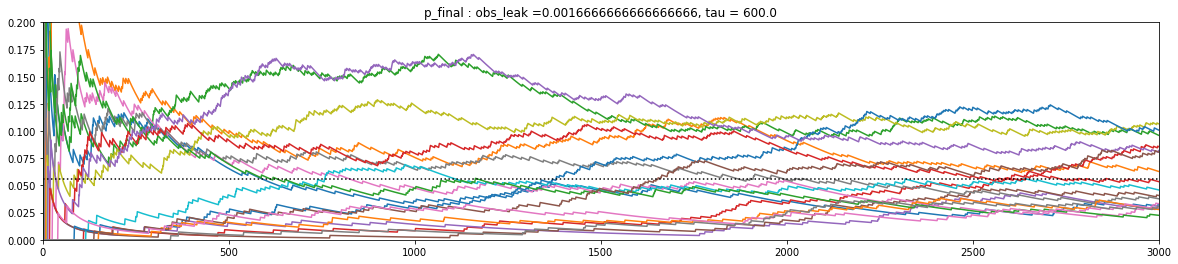

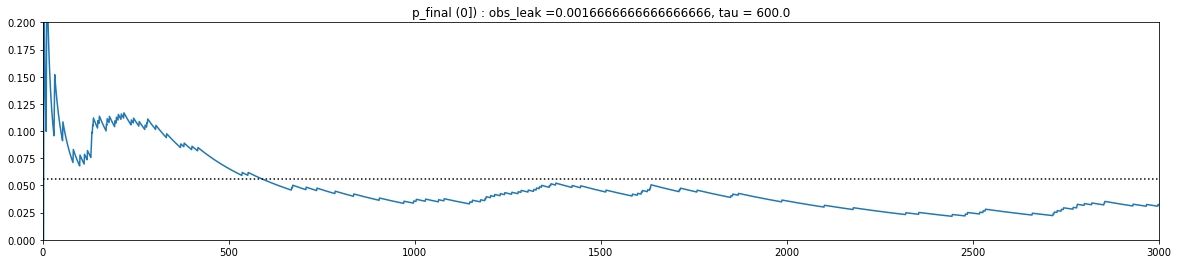

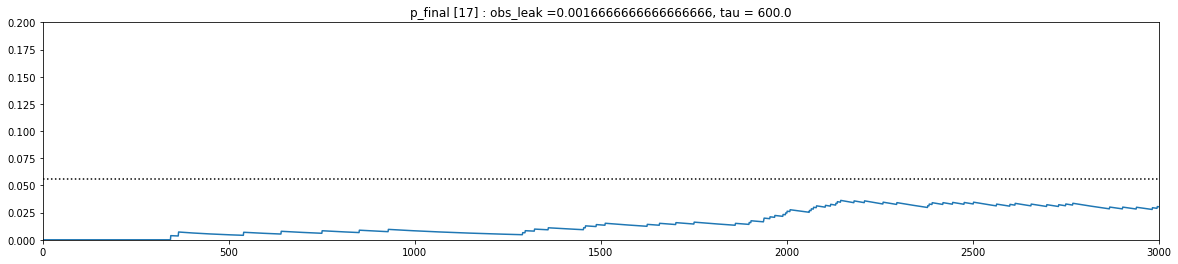

In [164]:
plt.figure(figsize=(20,4))
plt.plot(mem_p_eff.T)
plt.ylim(0,.2)
plt.xlim(0,trainer.nb_trials)
plt.title('p_final : obs_leak =' + str (args.OBS_LEAK) + ', tau = ' + str(1/args.OBS_LEAK))
plt.plot((0,N), (1/env.N_obs, 1/env.N_obs),':k')
plt.figure(figsize=(20,4))
plt.plot(mem_p_eff[0,:])
plt.ylim(0,.2)
plt.xlim(0,trainer.nb_trials)
plt.title('p_final (0]) : obs_leak =' + str (args.OBS_LEAK) + ', tau = ' + str(1/args.OBS_LEAK))
plt.plot((0,N), (1/env.N_obs, 1/env.N_obs),':k')
plt.figure(figsize=(20,4))
plt.plot(mem_p_eff[env.N_obs-1,:])
plt.ylim(0,.2)
plt.xlim(0,trainer.nb_trials)
plt.title('p_final ['+str(env.N_obs-1)+'] : obs_leak =' + str (args.OBS_LEAK) + ', tau = ' + str(1/args.OBS_LEAK))
plt.plot((0,N), (1/env.N_obs, 1/env.N_obs),':k')

In [165]:
mem_Q_var_arr = np.array(mem_Q_var)
mem_Q_var_flat = mem_Q_var_arr.reshape((trainer.nb_trials, -1))
if not args.monte_carlo:
    mem_Q_KL_arr = np.array(mem_Q_KL)
    mem_Q_KL_flat = mem_Q_KL_arr.reshape((trainer.nb_trials, -1))

In [166]:
if not args.monte_carlo:
    plt.figure(figsize=(20,4)); ax=plt.subplot(111)
    ax.plot(mem_Q_KL_flat)
    ax.set_xlim(0,trainer.nb_trials)
    plt.title('Q_KL update, alpha :' + str (args.ALPHA) + ', tau = ' + str(1/args.ALPHA))

Text(0.5, 1.0, 'Q_var update, alpha :0.03, tau = 33.333333333333336')

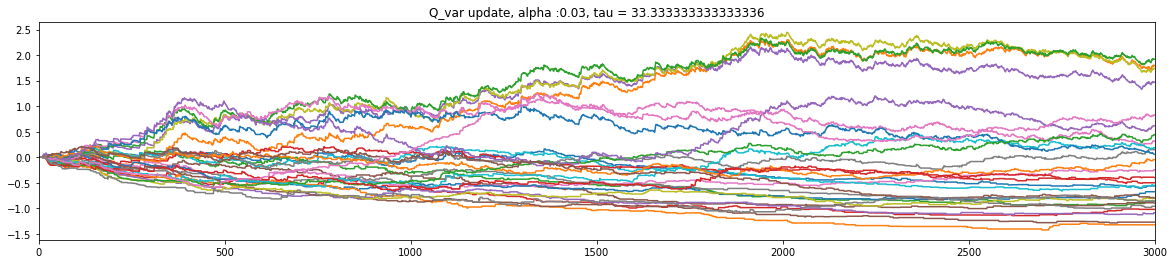

In [167]:
plt.figure(figsize=(20,4)); ax=plt.subplot(111)
ax.plot(mem_Q_var_flat)
ax.set_xlim(0,trainer.nb_trials)
plt.title('Q_var update, alpha :' + str (args.ALPHA) + ', tau = ' + str(1/args.ALPHA))

(0.0, 3000.0)

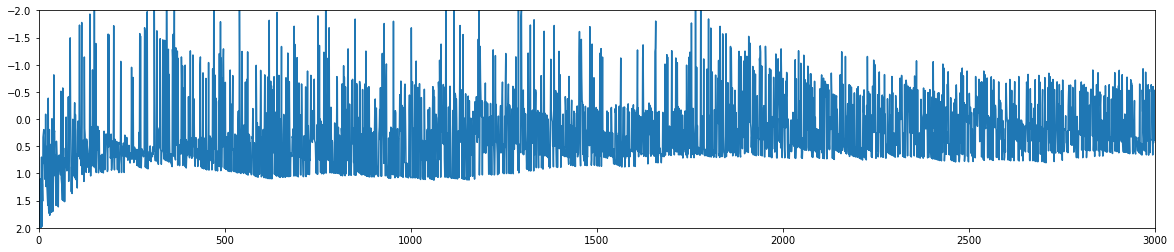

In [168]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_KL)
ax.set_ylim(2,-2)
ax.set_xlim(0,trainer.nb_trials)

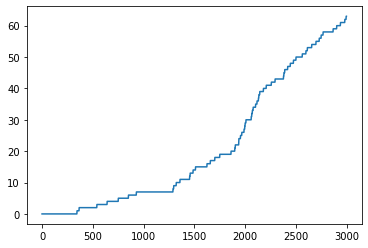

In [169]:
plt.plot(np.cumsum(trainer.mem_total_reward))

(0.0, 3000.0)

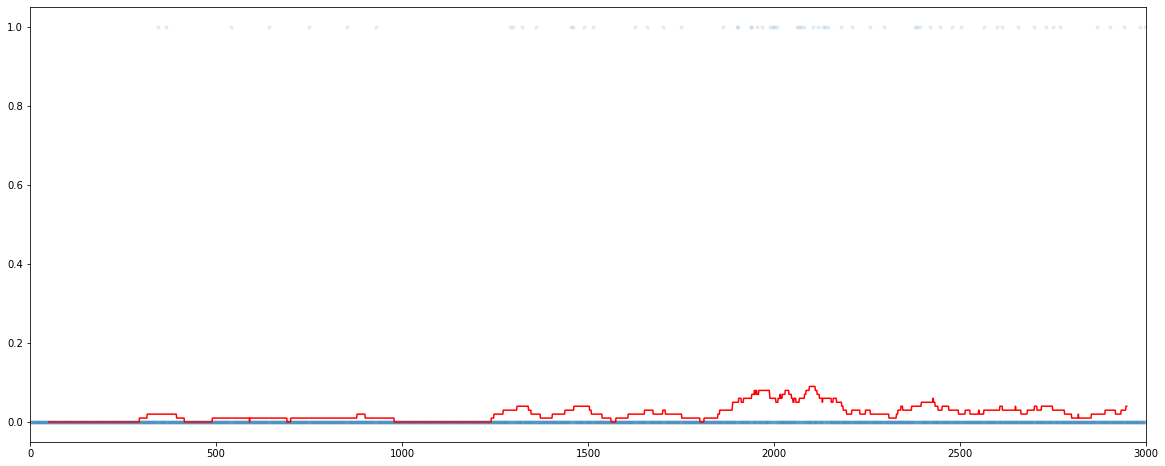

In [170]:
plt.figure(figsize=(20,8))
plt.plot(trainer.mem_total_reward,'.',alpha=.1)
plt.plot(range(50, N-51), np.convolve(trainer.mem_total_reward, np.ones(100)/100)[100:-100], 'r')
plt.xlim(0,N)

(0.0, 3000.0)

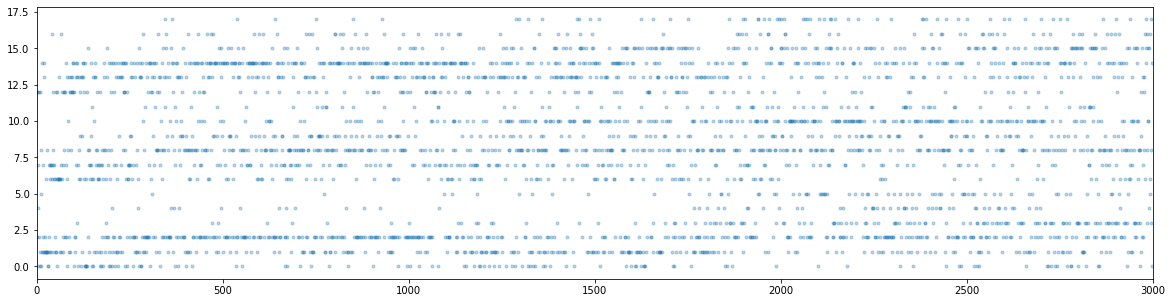

In [171]:
plt.figure(figsize=(20,5)); ax=plt.subplot(111)
ax.plot(trainer.mem_obs_final, '.', alpha=.3)
ax.set_xlim(0,N)

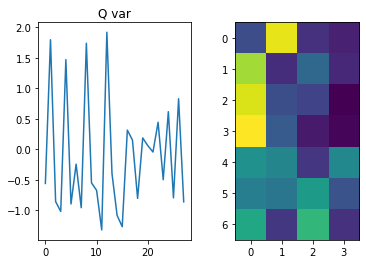

In [172]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab[:8,:])

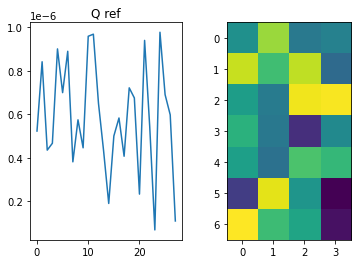

In [173]:
plt.subplot(1,2,1)
plt.plot(agent.Q_ref_tab.flatten())
plt.title('Q ref')
plt.subplot(1,2,2)
plt.imshow(agent.Q_ref_tab[:8,:])

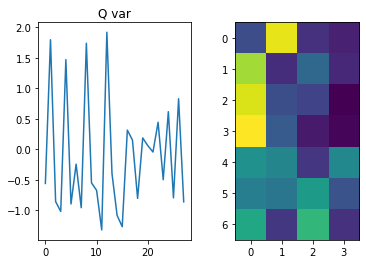

In [174]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab)

In [175]:
trial=0
v_min=0
v_max = 0.16
savefigs = False

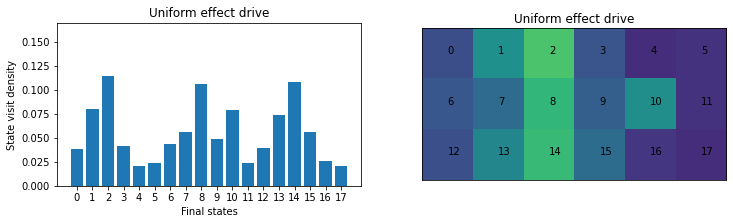

In [176]:
plt.figure(figsize = (12,3))
ax = plt.subplot(1,2,1)
plt.bar(range(env.N_obs), nb_visits_final[trial] / N)
ax.set_xticks(range(18))
plt.xlabel('Final states')
plt.ylabel('State visit density')
plt.ylim([0,0.17])
plt.title('Uniform effect drive')

ax = plt.subplot(1,2,2)
plt.imshow(nb_visits_final[trial].reshape(3,6)/ N, vmin=v_min, vmax=v_max)
for j in range(6):
    for i in range(3):
        plt.text(j,i,6*i+j)

ax.set_xticks([])
ax.set_yticks([])
plt.title('Uniform effect drive')

if savefigs:
    plt.savefig('botteneck-uniform-drive.png', bbox_inches='tight')

In [177]:
trainer.nb_trials

3000

In [178]:
obs_nb_visit = np.zeros((env.N_obs, trainer.nb_trials))
obs_p = np.zeros((env.N_obs, trainer.nb_trials))
for obs in range(env.N_obs):
    obs_nb_visit[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs)
    obs_p[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs) / (np.arange(trainer.nb_trials)+1)
    

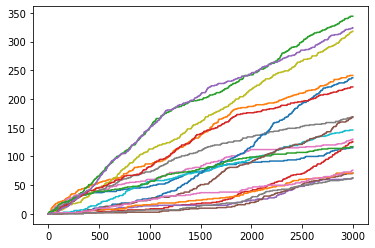

In [179]:
_ = plt.plot(obs_nb_visit.T)

(0.0, 0.2)

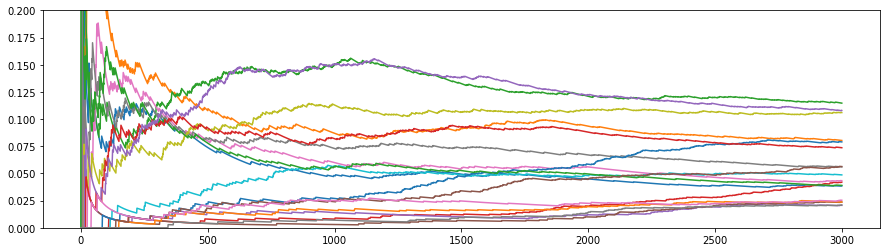

In [180]:
plt.figure(figsize=(15,4))
plt.plot(obs_p.T)
plt.ylim((0,0.2))

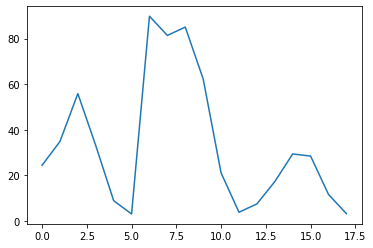

In [181]:
plt.plot(trainer.obs_score)

In [182]:
trainer.ref_probs

array([0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556])

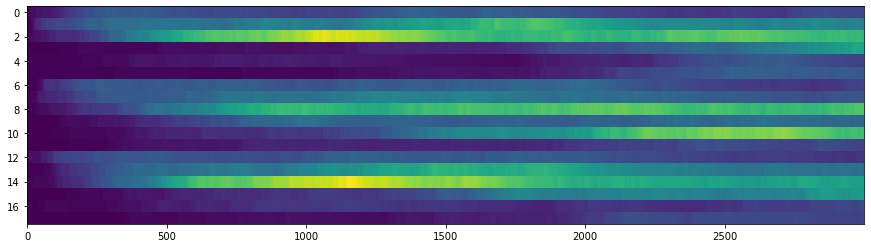

In [183]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_obs_score, aspect='auto', interpolation='nearest')

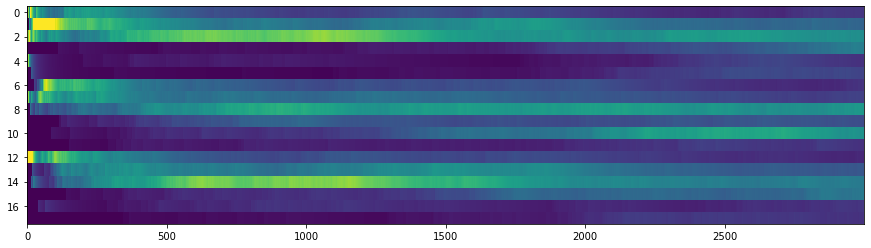

In [184]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_p_eff, aspect='auto', interpolation='nearest', vmin=0, vmax=0.2)

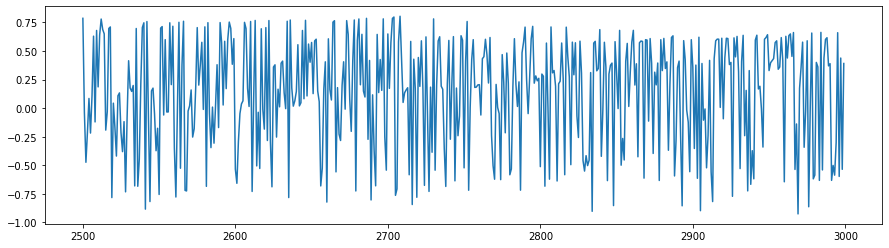

In [185]:
plt.figure(figsize=(15,4))
ax=plt.subplot(111)
ax.plot(range(2500,3000), mem_KL[2500:3000])
#ax.set_ylim(1,-1)
#ax.set_xlim(4500,5000)

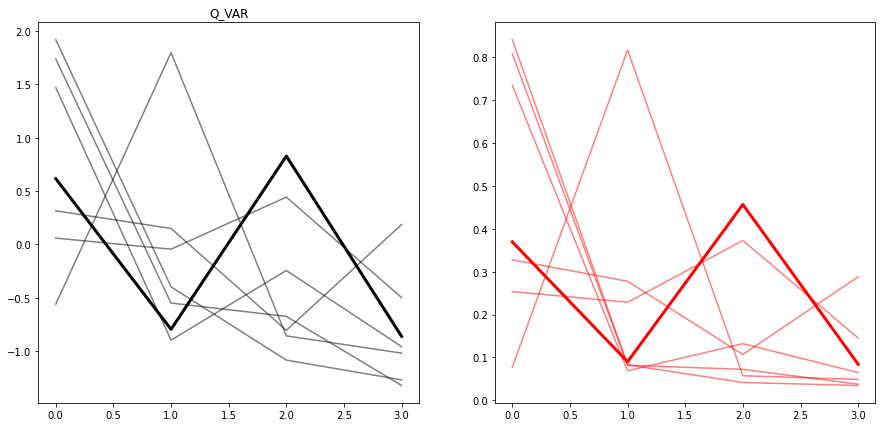

In [186]:
#obs = trainer.agent.get_observation()
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in range(7):
    actions_set = None #trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)    
    ax1.set_title('Q_VAR') # : MEAN RTG :' + str(m_rtg))
    ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', alpha=.5)
#ax1.plot((1,trainer.N_PART), (m_rtg, m_rtg), 'r')
ax1.plot(Q_obs,'k',linewidth=3)
ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', linewidth=3)

## TRIAL

0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'TRIAL : ACTION')

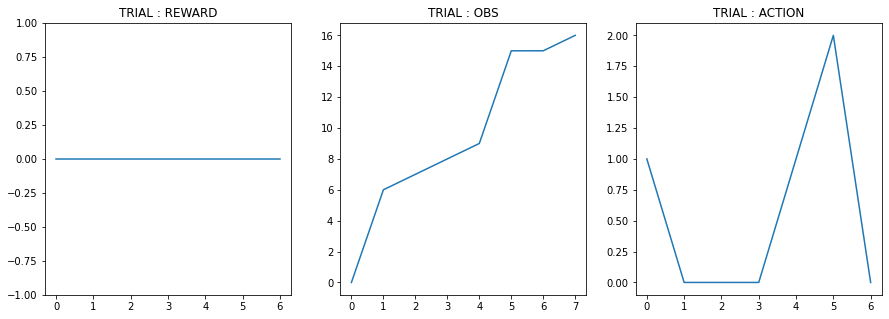

In [187]:
%matplotlib tk
#agent.env=env
trainer.run_episode(render=True)

%matplotlib inline
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.title('TRIAL : REWARD')
plt.subplot(1,3,2)
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.title('TRIAL : OBS')
plt.subplot(1,3,3)
plt.plot(trainer.action_history)
plt.title('TRIAL : ACTION')
#obs = trainer.agent.get_observation()
